## Trabalho 1 — INF-0618 Deep Learning   


Alunos:
- [Aluno1]
- [Aluno2]
- [Aluno3]

Neste trabalho, vamos utilizar o conjunto de dados GeoDE. Este conjunto de dados possui imagens de objetos comuns, fotografados em diferentes lugares do mundo, por diferentes voluntários. O conjunto original possui imagens de diversos tamanhos e 40 objetos diferentes, fotografados em 6 regiões diferentes do planeta.

A ideia do conjunto é ser inclusivo com as diferentes sociedades. Um fogão na Europa é igual ao da Índia? Muitas vezes não. O artigo deste conjunto de dados, publicado [neste link](https://geodiverse-data-collection.cs.princeton.edu/), demonstra que modelos treinados no conjunto de dados da ImageNet tem uma queda de performance consideravel ao serem testados em objetos de outras localidades, mas que teoricamente o modelo já conhecia.

Neste trabalho iremos trabalhar com um subconjunto desse conjunto de dados, para limitar a quantidade de hardware necessário, usando apenas 4 classes. Além disso, todas as imagens foram previamente redimensionadas para a resolução de 300x400, e disponibilizadas em uma pasta compartilhada no google drive ([neste link](https://drive.google.com/drive/folders/1OYDEVPH52LF0Z4hg5uq3LnvsWB61_5zA?usp=sharing)). Para utilizar os dados no Google Colab, é necessário criar um atalho dessa pasta para o seu Google Drive (ao acessar a pasta, tem uma seta para baixo perto do nome da pasta > organizar > adicionar atalho).

O dataset reduzido é composto por 7768 imagens, distribuídas por classes da seguinte maneira:
- Car: 1721 amostras
- House: 1510 amostras
- Bag: 2362 amostras
- Chair: 2175 amostras

![Classes do dataset ](figures/classes_geode.png)


## Importando bibliotecas

Todas já estão instaladas no Google Colab. Caso localmente algum import falhe, a biblioteca específica deve ser instalada.

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Baixar e carregar os dados

Os dados estão no [link do drive](https://drive.google.com/drive/folders/1OYDEVPH52LF0Z4hg5uq3LnvsWB61_5zA?usp=sharing), na pasta "GeoDE_tf".

Para rodar localmente, o dataset deve ser baixado e colocado na mesma pasta deste notebook.

As células abaixo demonstram como rodar no Google Colab, primeiro montando o drive, e então copiando o dataset para o ambiente atual (isso aumenta MUITO a velocidade de acesso de dados, pois o drive é mais lento).

In [1]:
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# O primeiro caminho é o local dentro do seu drive que o dataset aparecerá (no caso, em shared drives),
# e o segundo o nome do dataset utilizado nas próximas células
# Esse comando só funcionará se o atalho da pasta foi corretamente adicionado ao seu Drive
!cp -r drive/MyDrive/MDC_Datasets/GeoDE_tf/ GeoDE_tf/

## Carregando e pré processando o dataset


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
import numpy as np

# --- Configuration ---
DATASET_DIR = "GeoDE_tf/"
IMAGE_WIDTH = 200
IMAGE_HEIGHT = 200
BATCH_SIZE = 256
SEED = 42
IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406])
IMAGENET_STD = tf.constant([0.229, 0.224, 0.225])
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

In [4]:
@tf.function
def imagenet_normalize(image, label):
  """
  Transforma as imagens para o intervalo [0, 1], que facilita o treinamento.
  Além disso, normaliza os dados de acordo com a média e desvio do dataset ImageNet.
  Isso é costume ao processar imagens naturais normalizadas.
  """
  # Transformar para [0,1]
  image = tf.cast(image, tf.float32) / 255.0

  # Fazer a normalização
  mean = tf.reshape(IMAGENET_MEAN, [1, 1, 3])
  std = tf.reshape(IMAGENET_STD, [1, 1, 3])
  image = (image - mean) / std

  return image, label

In [ ]:
def load_and_split_dataset(data_dir, img_height, img_width, batch_size, seed):
  """
  Carrega o dataset a partir da pasta em "data_dir"
  Os rotulos sao inferidos pelo nome das pastas, e separados em treino,
    validacao e teste (60-20-20).
  Alem disso, as imagens sao redimensionadas de acordo com img_height e img_width.

  Os datasets sao retornados ja em batches, de forma a diminuir consumo de memoria.

  Retorna os datasets de treino, validacao e teste, e o nome das classes encontradas.
  """
  data_dir = pathlib.Path(data_dir)
  image_count = len(list(data_dir.glob('*/*.png')))

  if image_count == 0:
    raise ValueError(f"Nenhuma imagem em {data_dir}. Verifique o caminho da pasta.")

  # Treino (60% dados)
  train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.4,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
  )

  # Pega os 40% restantes para validacao e teste
  val_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.4,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
  )

  class_names = train_ds.class_names

  # Para separar validacao e teste, precisamos fazer por batches
  total_val_batches = tf.data.experimental.cardinality(val_test_ds).numpy()

  # Separa em 2
  val_ds = val_test_ds.take(total_val_batches // 2)
  test_ds = val_test_ds.skip(total_val_batches // 2)

  print(f"\nTotal de imagens: {image_count}")
  print(f"Classes: {class_names}")
  print(f"Batches de treino: {tf.data.experimental.cardinality(train_ds).numpy()}")
  print(f"Batches de validacao: {tf.data.experimental.cardinality(val_ds).numpy()}")
  print(f"Batches de teste: {tf.data.experimental.cardinality(test_ds).numpy()}")

  # Agora aplicamos a normalizacao nos tres conjuntos
  AUTOTUNE = tf.data.AUTOTUNE
  train_ds = train_ds.map(imagenet_normalize, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.map(imagenet_normalize, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)
  test_ds = test_ds.map(imagenet_normalize, num_parallel_calls=AUTOTUNE).cache().prefetch(buffer_size=AUTOTUNE)

  return train_ds, val_ds, test_ds, class_names

In [6]:
train_ds, val_ds, test_ds, class_names = load_and_split_dataset(
        DATASET_DIR, IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE, SEED
    )

Found 7772 files belonging to 4 classes.
Using 4664 files for training.
Found 7772 files belonging to 4 classes.
Using 3108 files for validation.

Total de imagens: 7767
Classes: ['bag', 'car', 'chair', 'house']
Batches de treino: 19
Batches de validacao: 6
Batches de teste: 7


In [7]:
NUM_CLASSES = len(class_names)
NUM_CLASSES

4

## Funções Auxiliares

In [ ]:
def  plot_loss_accuracy():
  # Implemente aqui
  pass

def  plot_confusion_matrix():
  # Implemente aqui
  pass

### Visualização dos dados

In [16]:
def plot_denormalized_images(dataset, class_names=class_names, n_row = 2, n_col = 6, figsize = (10, 8)):
  """
  Mostra imagens com rótulo, removendo a normalização antes do plot.
  Para mostrar mais/menos imagens, utilizem os parâmetros de n_row e n_col.
  """

  # Pega um batch de imagens do dataset
  images_batch, labels_batch = next(iter(dataset))

  # Converte para numpy
  images_np = images_batch.numpy()
  labels_np = labels_batch.numpy()

  # Seleciona algumas imagens para plotar
  n_images_to_plot = min(n_row * n_col, len(images_np))
  imgList = images_np[:n_images_to_plot]
  labels = labels_np[:n_images_to_plot]

  # Tira a normalização feita anteriormente
  mean = IMAGENET_MEAN.numpy().reshape(1, 1, 1, 3)
  std = IMAGENET_STD.numpy().reshape(1, 1, 1, 3)
  denormalized_images = (imgList * std) + mean
  denormalized_images = np.clip(denormalized_images * 255.0, 0, 255).astype(np.uint8)

  # Plot das imagens
  fig, axs = plt.subplots(n_row, n_col, figsize=figsize)
  axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]

  for i, (img, ax) in enumerate(zip(denormalized_images, axs)):
      ax.imshow(img)

      if labels is not None and i < len(labels):
          label_idx = labels[i]
          if 0 <= label_idx < len(class_names):
              ax.set_title(class_names[label_idx], fontsize=10)
      ax.axis('off')

  # Remove os axes que não foram utilizados
  for ax in axs[len(denormalized_images):]:
      ax.axis('off')

  plt.tight_layout()
  plt.suptitle("Imagens do dataset (parte do primeiro batch)", fontsize=14)
  plt.show()

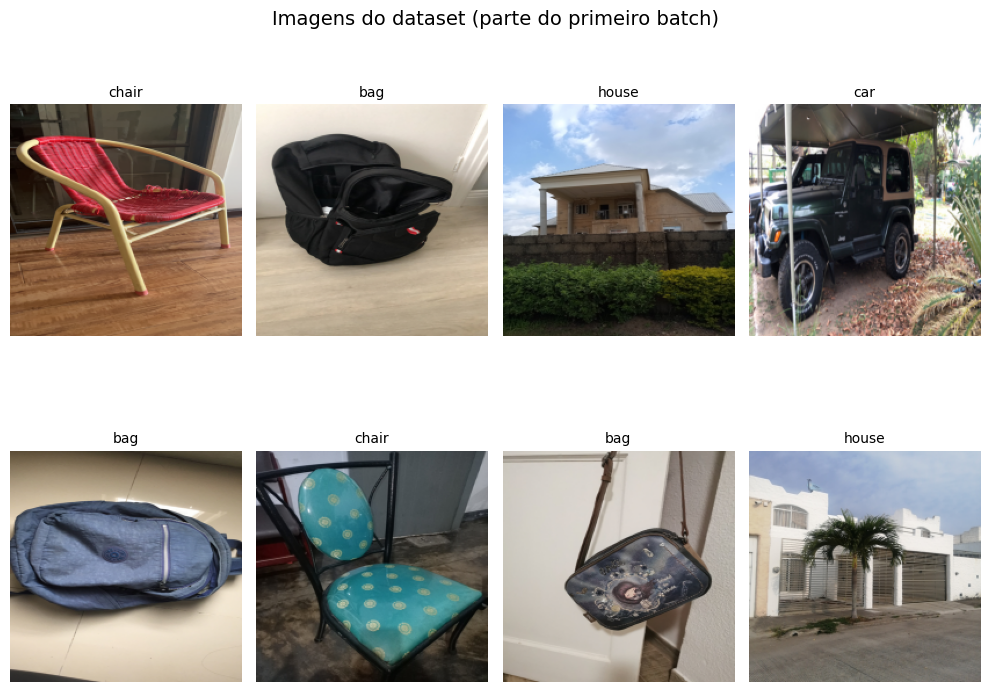

In [17]:
plot_denormalized_images(
        dataset=train_ds,
        class_names=class_names,
        n_row=2,
        n_col=4,
    )

## Atividade

Para cada questão proposta, descreva detalhadamente os experimentos realizados e apresente uma análise aprofundada dos resultados obtidos. É essencial criar gráficos que mostrem a relação entre a função de perda (loss) e o número de épocas, considerando os dados de treinamento e de validação para cada modelo. Além disso, apresente a matriz de confusão em termos relativos. Identificar sinais de  overfitting é crucial para avaliar a capacidade de generalização do modelo; portanto, baseando-se nos gráficos elaborados, discuta quaisquer indícios que possam sugerir que o modelo está se ajustando excessivamente aos dados de treinamento

Nota Importante: O conjunto de teste deve ser utilizado apenas uma vez, no final de todas as experimentações!

### Projeção e Treinamento de uma Rede Neural Convolucional Simples (Baseline)

1. (1.5) Projete e treine uma rede neural convolucional simples como modelo básico (baseline), construindo-a do zero sem utilizar arquiteturas pré-existentes. Por exemplo, você pode iniciar com uma arquitetura que contenha apenas uma ou duas camadas convolucionais e de pooling. Lembre-se: quanto mais simples for a arquitetura inicial, melhor será para avaliar o impacto de futuras melhorias.

In [ ]:
# Seus código aqui! Utilize quantas células quiser (tanto de código quanto markdown)!

Discussão:

### Variação do Número de Camadas de Convolução e Pooling

2. (1.5) Explore o impacto de variar o número de camadas de convolução e pooling em **pelo menos duas** arquiteturas diferentes em relação ao modelo baseline. Ao construir essas arquiteturas, experimente diferentes funções de ativação, inicializações e regularizações, e considere o uso de dropout na camada totalmente conectada. Visite http://keras.io para descobrir quais funções de ativação e outros componentes estão disponíveis. Não se esqueça de plotar os gráficos da função de perda loss em relação ao número de épocas, tanto para o treino quanto para a validação de cada modelo. Tenha cuidado com o overfitting.


In [ ]:
# Seus código aqui! Utilize quantas células quiser (tanto de código quanto markdown)!

Discussão:

### Treinamento com Arquitetura Pré-Treinada (ImageNet)

3. (1.5) Escolha uma arquitetura de rede neural que tenha sido pré-treinada na ImageNet e seja adequada para extração de características. Descarte a camada de saída original e congele todas as demais camadas da arquitetura. Em seguida, adicione uma nova camada de saída que corresponda ao número de classes específicas do problema. Prossiga com o treinamento apenas dessa nova camada.
Após concluir o treinamento, compare o desempenho dessa arquitetura com o melhor modelo que você desenvolveu anteriormente.


In [ ]:
# Seus código aqui! Utilize quantas células quiser (tanto de código quanto markdown)!

Discussão:

### Ajuste Fino das Camadas de Extração de Características

4. (1.5) Usando a mesma arquitetura da questão anterior, descongele as camadas da rede responsáveis pela extração de características e realize o ajuste fino (fine-tuning) dessa parte do modelo junto com a nova camada de decisão. Em seguida, compare os novos resultados com os obtidos anteriormente, analisando detalhadamente as diferenças e identificando possíveis melhorias no desempenho. (Obs: Um novo modelo deve ser instanciado)



Discussão:

### Seleção do Modelo com Melhor Acurácia Balanceada
5. (2.0) Selecione o modelo com a melhor acurácia balanceada e avalie-o utilizando o conjunto de teste. De forma clara e objetiva, destaque os principais desafios enfrentados durante o treinamento, explicando as estratégias adotadas para superá-los. Reflita também sobre a escolha dos hiperparâmetros, discutindo como essas decisões podem ter impactado o desempenho final do modelo.


In [ ]:
# Seus código aqui! Utilize quantas células quiser (tanto de código quanto markdown)!

Discussão:

### Aplicação do Grad-CAM para Visualização de Classes

6. (2.0) Utilizando o modelo com a melhor acurácia balanceada, aplique a técnica de visualização Grad-CAM para cada classe do conjunto de dados. Para cada classe, escolha duas imagens: uma corretamente classificada e outra incorretamente classificada pelo modelo. Use o Grad-CAM para identificar as áreas das imagens que mais influenciaram as previsões do modelo. Descreva suas observações sobre as regiões destacadas e discuta suas conclusões a partir dessa análise.

- Abaixo esta declarado uma implementação do algoritmo Grad-CAM e um exemplo de uso.

#### O algoritmo Grad-CAM

In [ ]:
from tensorflow import keras
import matplotlib as mpl

def get_img_array(img_path, size):
  '''
  Carrega uma imagem a partir de um endereço, transforma em um array e em um batch.
  Espera uma imagem colorida (3 canais).
  '''
  # `img` é uma imagem PIL de tamanho 299x299
  img = keras.utils.load_img(img_path, target_size=size)
  # `array` é um array Numpy float32 com forma (299, 299, 3)
  array = keras.utils.img_to_array(img)
  # Adicionamos uma dimensão para transformar nosso array em um "batch"
  # de tamanho (1, 299, 299, 3)
  array = np.expand_dims(array, axis=0)

  return array

def unwrap_model(model, last_conv_layer_name, base_model_name):
  '''
  Essa função extrai os outputs de um modelo aninhado dentro do modelo principal.
  Por exemplo: caso o modelo utilize uma resnet como extrator de características,
  se a ultima camada convolucional for do modelo da resnet, 'last_conv_layer_name'
  apenas será visível a partir do modelo aninhado.
  '''
  n_model = model.get_layer(base_model_name)
  n_model_conv_out = n_model.get_layer(last_conv_layer_name).output
  inp = n_model.input

  # Executa o resto da rede, supondo que o modelo base era a primeira camada
  other_layers = model.layers[1:]
  curr_out = n_model_conv_out
  for layer in other_layers:
    curr_out = layer(curr_out)

  return tf.keras.models.Model(inp, [n_model_conv_out, curr_out])

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None, base_model_name=None):
  # Primeiro, criamos um modelo que mapeia a imagem de entrada para as ativações
  # da última camada convolucional, bem como as previsões de saída
  # Caso o modelo utilize um outro modelo pré treinado (fine-tunning), e sua ultima
  # camada convolucional esteja dentro deste modelo, usamos o parâmetro base_model_name
  # para criarmos o modelo do GradCAM.
  if  base_model_name is None:
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.layers[-1].output]
    )
  else:
    grad_model = unwrap_model(model, last_conv_layer_name, base_model_name)

  # Em seguida, computamos o gradiente da classe prevista no topo para nossa imagem de entrada
  # em relação às ativações da última camada convolucional
  with tf.GradientTape() as tape:
      last_conv_layer_output, preds = grad_model(img_array)
      if pred_index is None:
          pred_index = tf.argmax(preds[0])
      class_channel = preds[:, pred_index]

  # Este é o gradiente do neurônio de saída (mais previsto ou escolhido)
  # em relação ao mapa de características de saída da última camada convolucional
  grads = tape.gradient(class_channel, last_conv_layer_output)

  # Este é um vetor onde cada entrada é a intensidade média do gradiente
  # sobre um canal específico do mapa de características
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  # Multiplicamos cada canal no array do mapa de características
  # por "quão importante esse canal é" em relação à classe prevista no topo
  # e então somamos todos os canais para obter o mapa de calor de ativação da classe
  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)

  # Para fins de visualização, também normalizamos o mapa de calor entre 0 e 1
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  return heatmap.numpy()

def denormalize_imagenet_image(normalized_img_np: np.ndarray) -> np.ndarray:
  """
  Reverses the ImageNet normalization process on a single image.
  Formula: original = (normalized * std) + mean

  Args:
      normalized_img_np: A NumPy array (H, W, C) with values normalized
                          using ImageNet mean/std.

  Returns:
      np.ndarray: The image array scaled to [0, 255] and cast to np.uint8.
  """
  # Reshape constants to (1, 1, 3) for broadcasting
  mean = IMAGENET_MEAN.numpy().reshape(1, 1, 3)
  std = IMAGENET_STD.numpy().reshape(1, 1, 3)

  # Reverse normalization: (normalized * std) + mean
  denormalized_img = (normalized_img_np * std) + mean

  # Rescale to [0, 255] and clip to handle minor floating point errors
  denormalized_img = np.clip(denormalized_img * 255.0, 0, 255)

  return denormalized_img.astype(np.uint8)

def show_heatmap_with_image(img, heatmap, alpha=0.5, denormalize_img=True):
  '''
  Mostra uma imagem junto de seu mapa de calor (heatmap).
  O parâmetro alpha controla a opacidade do mapa de calor.
  '''
  # Redimensionar o mapa de calor e imagem para o intervalo de 0 a 255
  heatmap = np.uint8(255 * heatmap)

  if denormalize_img:
    img = denormalize_imagenet_image(img)

  # Usar o mapa de cores 'jet' para colorir o mapa de calor
  jet = mpl.colormaps["jet"]

  # Usar os valores RGB do mapa de cores
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  # Criar uma imagem com o mapa de calor colorizado em RGB
  jet_heatmap = keras.utils.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = keras.utils.img_to_array(jet_heatmap)

  # Sobrepor o mapa de calor na imagem original
  superimposed_img = jet_heatmap * alpha + img
  superimposed_img = keras.utils.array_to_img(superimposed_img)

  plt.figure(figsize=(12, 6))
  plt.imshow(superimposed_img, cmap="jet")
  plt.title("Grad-CAM Heatmap")
  plt.grid(False)
  plt.axis('off')
  plt.colorbar()
  plt.show()

#### Exemplo de Visualização de Ativações de Classe com Grad-CAM

##### Parâmetros configuráveis
Esses parâmetros devem ser alterados para o seu modelo.

Para obter os valores de last_conv_layer_name, utilize o comando model.summary(), que exibirá os nomes de todas as camadas do modelo.

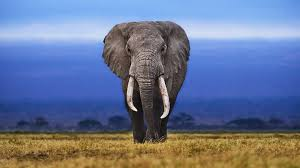

In [ ]:
from IPython.display import Image, display

model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2_act"

img_path = keras.utils.get_file(
    "african_elephant.jpg",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSFnDnhqw5kPYKQ8g0lmNj6N-lpRTbyo_tJhw&s"
)

display(Image(img_path))


##### Executando o algoritmo gradcam e visualizando o resultado

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Previsto: [('n01871265', 'tusker', np.float32(0.52014345))]


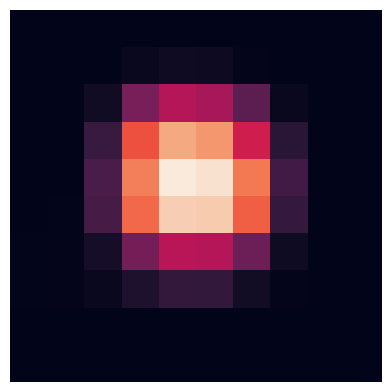

In [ ]:
# Preparar a imagem
img_array = preprocess_input(get_img_array(img_path, size=img_size))
# img_array = tf.convert_to_tensor(preprocess_input(get_img_array(img_path, size=img_size)))

# Construir o modelo
Xception_model = model_builder(weights="imagenet")

# Remover a função softmax da última camada
# Xception_model.layers[-1].activation = None

# Imprimir qual é a classe prevista no topo
preds = Xception_model.predict(img_array)
print("Previsto:", decode_predictions(preds, top=1)[0])

# Converte para tensor para evitar warnings do Keras
# img_array = tf.convert_to_tensor([img_array])

# Gerar o mapa de calor de ativação da classe
heatmap = make_gradcam_heatmap(
    [img_array],
    Xception_model,
    last_conv_layer_name)

# Isso também poderia ser feito de outra forma como:
# heatmap = make_gradcam_heatmap(
#     input_batch,
#     model,
#     last_conv_layer_name,  # Nome da ultima camada convolucional específicamente
#     base_model_name # nome do modelo "base", caso seja um modelo de transfer learning com modelo,
#                                               avg pooling (ou flatten) e uma camada de ativacao
# )

# Exibir o mapa de calor
plt.matshow(heatmap)
plt.grid(False)
plt.axis('off')
plt.show()


In [ ]:
heatmap.shape

(10, 10)

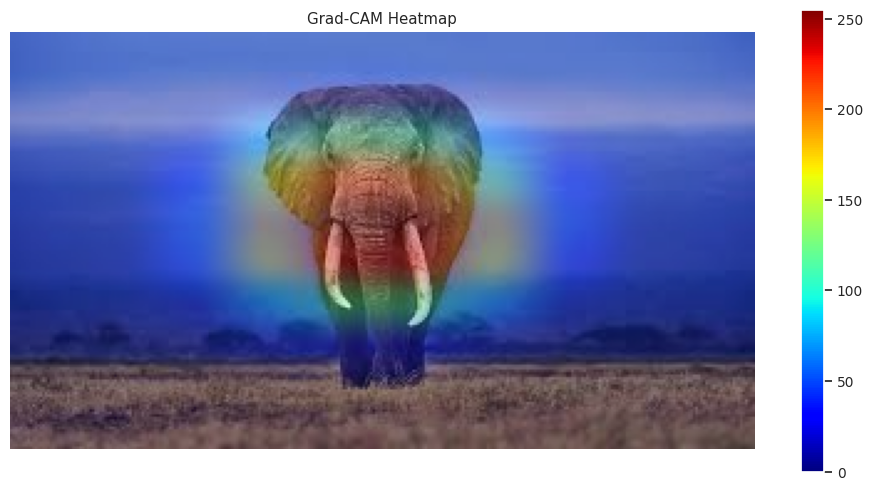

In [ ]:
img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

show_heatmap_with_image(img, heatmap, denormalize_img=False)

#### Agora é sua vez ...


In [ ]:
# Seus código aqui! Utilize quantas células quiser (tanto de código quanto markdown)!

Discussão: